## Classification Model

In [ ]:
#-----------------------------------packages-----------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import (train_test_split, StratifiedKFold,
                                     cross_val_score)
from sklearn.preprocessing import OneHotEncoder

import lightgbm as lgb

from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_curve, roc_auc_score, log_loss)

In [2]:
#----------------------------------load data-----------------------------------
data = pd.read_csv('data/class_data.csv')

We first split the data randomly into a test set and train set with $80\%$ of the data going to the train set.

In [3]:
#------------------------------train-test split--------------------------------
X, y = data.drop('default_ind', axis = 1), data['default_ind']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,
                                                    shuffle = True)

We then encode the categorical columns, fitting the encoder to the train data and then transforming both the test and train sets.

In [10]:
#------------------------------encoding columns--------------------------------
encoding_cols = data.select_dtypes(exclude = [np.number, bool]).columns

encoder = OneHotEncoder(handle_unknown = 'ignore')
encoder.fit(X_train[encoding_cols])

def encode_data(X):
       return X.drop(encoding_cols, axis = 1).reset_index(drop = True).join(
              pd.DataFrame(encoder.transform(X[encoding_cols]).toarray()))

X_train = encode_data(X_train)
X_test = encode_data(X_test)


In [16]:
def model_train(X, y):
    
    model = lgb.LGBMClassifier()
    
    model.fit(X, y)
    return model

model = model_train(X_train, y_train)

MemoryError: 

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    256238
           1       0.00      0.00      0.00       311

    accuracy                           1.00    256549
   macro avg       0.50      0.50      0.50    256549
weighted avg       1.00      1.00      1.00    256549

no defaults: roc auc = 0.500
model prediction: roc auc = 0.647


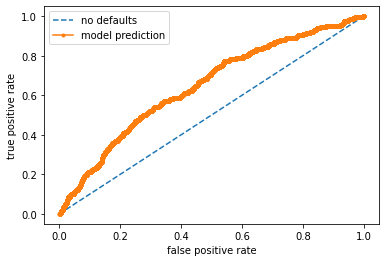

In [ ]:
def model_eval(model):

#-----------------predictions-----------------------    
    prob_default = model.predict_proba(X_test)[:,1]
#-------------------metrics-------------------------    
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred))

    false_auc = roc_auc_score(y_test, y_test.clip(upper = False))
    model_auc = roc_auc_score(y_test, prob_default)
    
    print('no defaults: roc auc = %.3f' % (false_auc))
    print('model prediction: roc auc = %.3f' % (model_auc))
    
    false_fpr, false_tpr, _ = roc_curve(y_test, y_test.clip(upper = False))
    model_fpr, model_tpr, _ = roc_curve(y_test, prob_default)

    plt.plot(false_fpr, false_tpr, linestyle = '--', label = 'no defaults')
    plt.plot(model_fpr, model_tpr, marker = '.', label = 'model prediction')

    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.legend()
    plt.show()

    return None
model_eval(model)